In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV

In [2]:
df=pd.read_excel("premiums_rest.xlsx")
print(df.shape)
df.head(3)

(29904, 13)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [3]:
df.columns=df.columns.str.replace(' ','_').str.lower()
#to replace all the spaces with the under score and to lower case
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [4]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

the data has very less no.of null rows as comppaared to the numner of rows available, so lets just drop them

In [5]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

df.duplicated().sum()
#if data present duplicate values
df.drop_duplicates(inplace=True)
df.duplicated().sum()

no duplicate values present in our data 

In [6]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


WE have to work on number_of_dependants because it cant be negative,age because age cannot be 356, income because 930 lakhs may be a outlier 

In [7]:
#number_of_dependants	 cannot be negative , but we can see negative values in the data set ,
#so lets look into them
print(df[df.number_of_dependants<0].shape)
df[df.number_of_dependants<0]["number_of_dependants"].unique()

(50, 13)


array([-1, -3])

In [8]:
#we have to duscuss with the that we should remove those 72 rows or make them positive
df["number_of_dependants"]=abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

now the df["number_of_dependants"] feature is fine

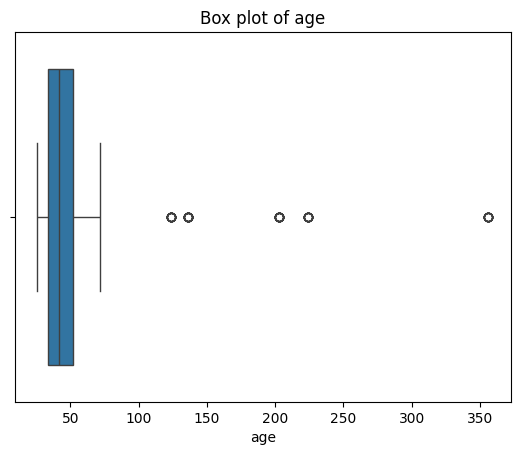

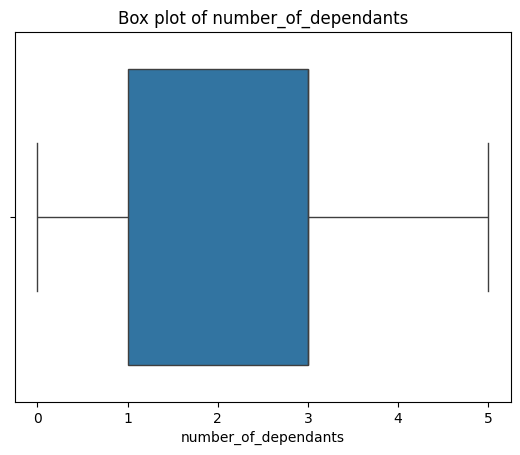

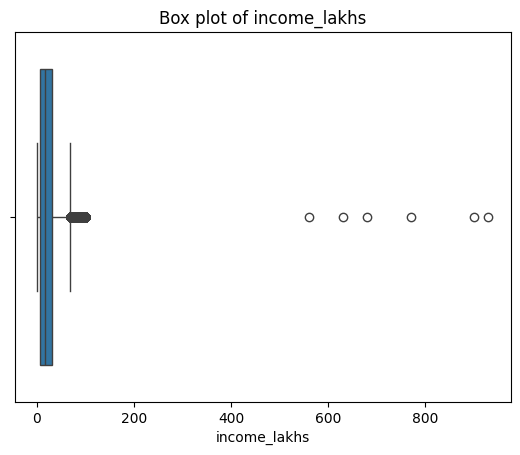

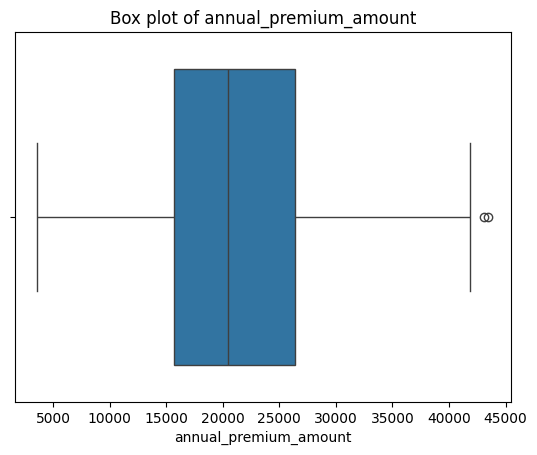

In [9]:
#lets work on outliers , plot box plot for each numeric column
numeric_columns=df.select_dtypes(["float64","int64"]).columns
for numeric_column in numeric_columns:
    sns.boxplot(x=df[numeric_column])
    plt.title(f'Box plot of {numeric_column}')
    plt.show()

##### age and income features have noticible outliers , which we have to deal with ; annual premium also as an outlier but normally a man can have greater annual plan , so it doesnt matter

In [10]:
# for age no need of using any stastical methods to handle outliers , simply can trim upto 100;
df[df.age>100].shape

(58, 13)

In [11]:
#58 rows have inoppropriate age , lets drop them and copy data into a new df , the orignaal df doesnt effected
df1=df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


#max age is 72 , it looks appropriate 

<Axes: xlabel='income_lakhs', ylabel='Count'>

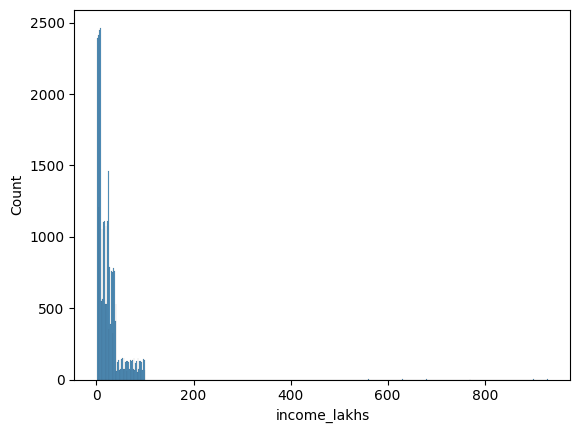

In [12]:
#now we have to work with income feature
sns.histplot(x=df1.income_lakhs)

In [13]:
def get_iqR_bounds(col):
    q1,q3=col.quantile([0.25,0.75])
    IQR=q3-q1
    lower_bound=q1-1.5*IQR
    upper_bound=q3+1.5*IQR
    return lower_bound,upper_bound
    

In [14]:
lower_bound,upper_bound=get_iqR_bounds(df1.income_lakhs)
lower_bound,upper_bound

(-30.5, 69.5)

we dont have to worry about lower bound because anyway our minimum value in income_lakhs feature is 1 and also 67 doesnt looks like a appropriate upper bound because , 67 lakhs in india is not that much , and so many people have more thean that , we have to discuss with the client , in this case lets use different method

In [15]:
quantile_treshold=df1.income_lakhs.quantile(0.999)
quantile_treshold

np.float64(100.0)

this looks goood , 1 crore income level is a decent level ,lets see how many aare lies more than that

In [16]:
df1[df1.income_lakhs>quantile_treshold].shape

(6, 13)

only 10 people have income more than our threshold , 100 in this case, lets drop them and store in new data frame df2

In [17]:
df2=df1[df1.income_lakhs<quantile_treshold]
df2[df2.income_lakhs>quantile_treshold].shape

(0, 13)

our new df has 0 been rows which have income more than our thrwshold

In [18]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29754.000000,29754.000000,29754.000000,29754.000000
mean,43.097432,2.387679,23.050884,20891.777811
std,11.043700,1.420724,22.178726,6929.595513
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15698.250000
50%,42.000000,3.000000,17.000000,20480.000000
75%,52.000000,3.000000,32.000000,26355.750000
max,72.000000,5.000000,99.000000,43471.000000


now we get rid of outliers , lets plot an histogram to get an understanding on the distribution of data

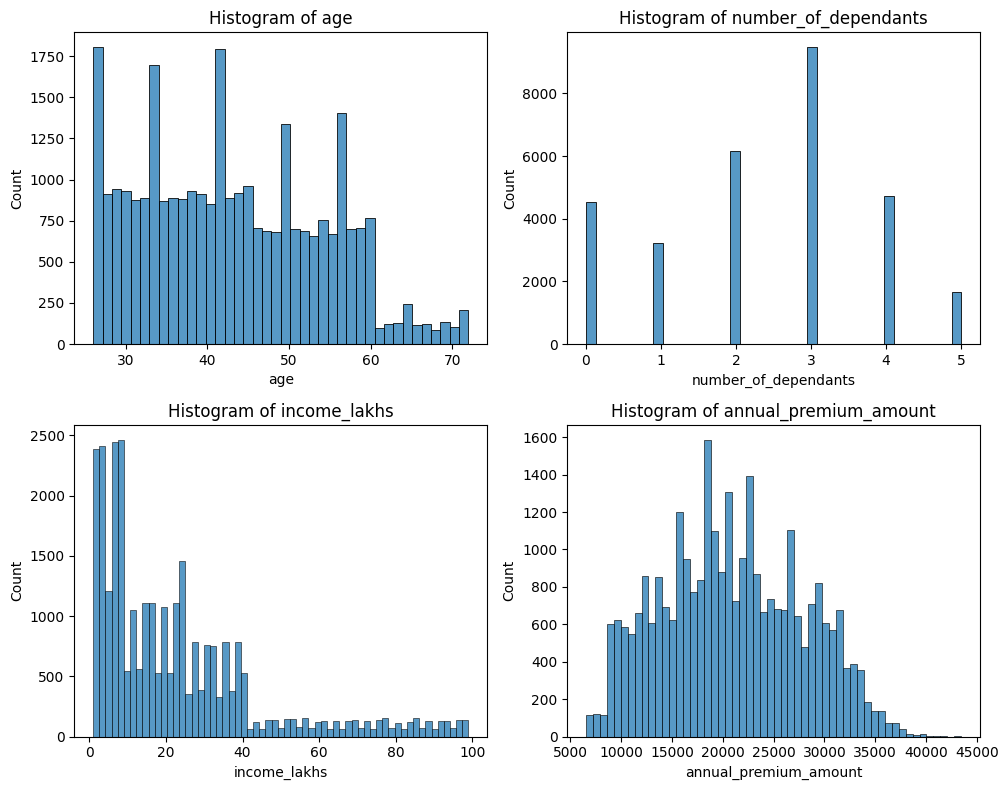

In [19]:
# Select numeric columns
numeric_columns = df2.select_dtypes(["float64", "int64"]).columns

# Create subplots with a fixed number of columns
fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(10, 8))

# Plot histograms in each subplot
for i, numeric_column in enumerate(numeric_columns):
    ax=axes[i//2,i%2]
    sns.histplot(x=df2[numeric_column], ax=ax)
    ax.set_title(f'Histogram of {numeric_column}')

# Adjust layout
plt.tight_layout()
plt.show()

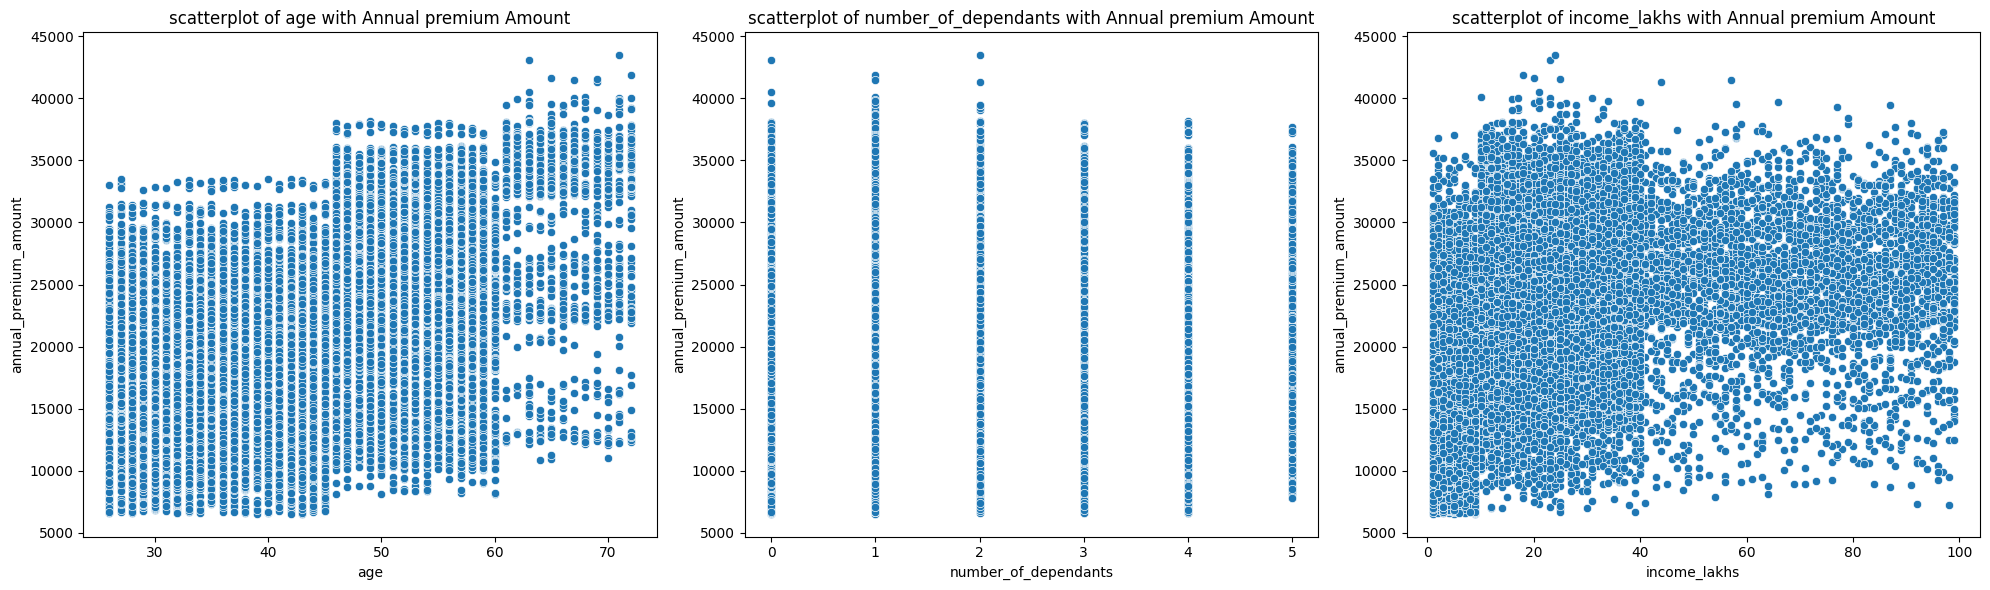

In [20]:
# Select numeric columns
numeric_columns = ['age','number_of_dependants','income_lakhs']

# Create subplots with a fixed number of columns
fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(20, 6))

# Plot histograms in each subplot
for i, numeric_column in enumerate(numeric_columns):
    ax=axes[i]
    sns.scatterplot(df2,x=numeric_column, y='annual_premium_amount', ax=ax)
    ax.set_title(f'scatterplot of {numeric_column} with Annual premium Amount')

# Adjust layout
plt.tight_layout()
plt.show()


#### lets deal catogerical columns

In [21]:
catogerical_cols=["gender",	"region","marital_status","bmi_category",	"smoking_status","employment_status","income_level","medical_history","insurance_plan"]
for col in catogerical_cols:
    print(col,":",df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [22]:
#unform the values
df["smoking_status"].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)

In [23]:
df["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [24]:
pct_count=df2['gender'].value_counts(normalize=True)
print(pct_count.values)
print(pct_count.index)

[0.54896821 0.45103179]
Index(['Male', 'Female'], dtype='object', name='gender')


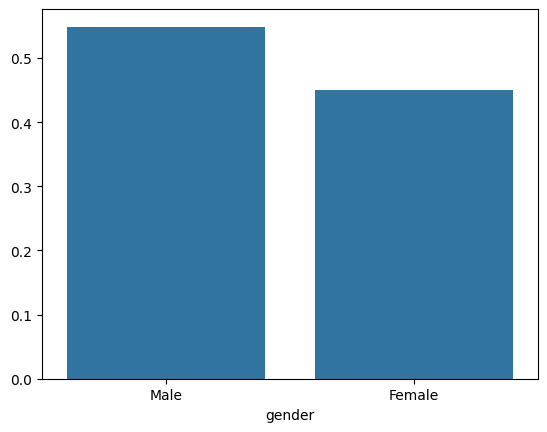

In [25]:
sns.barplot(x=pct_count.index,y=pct_count.values)
plt.show()

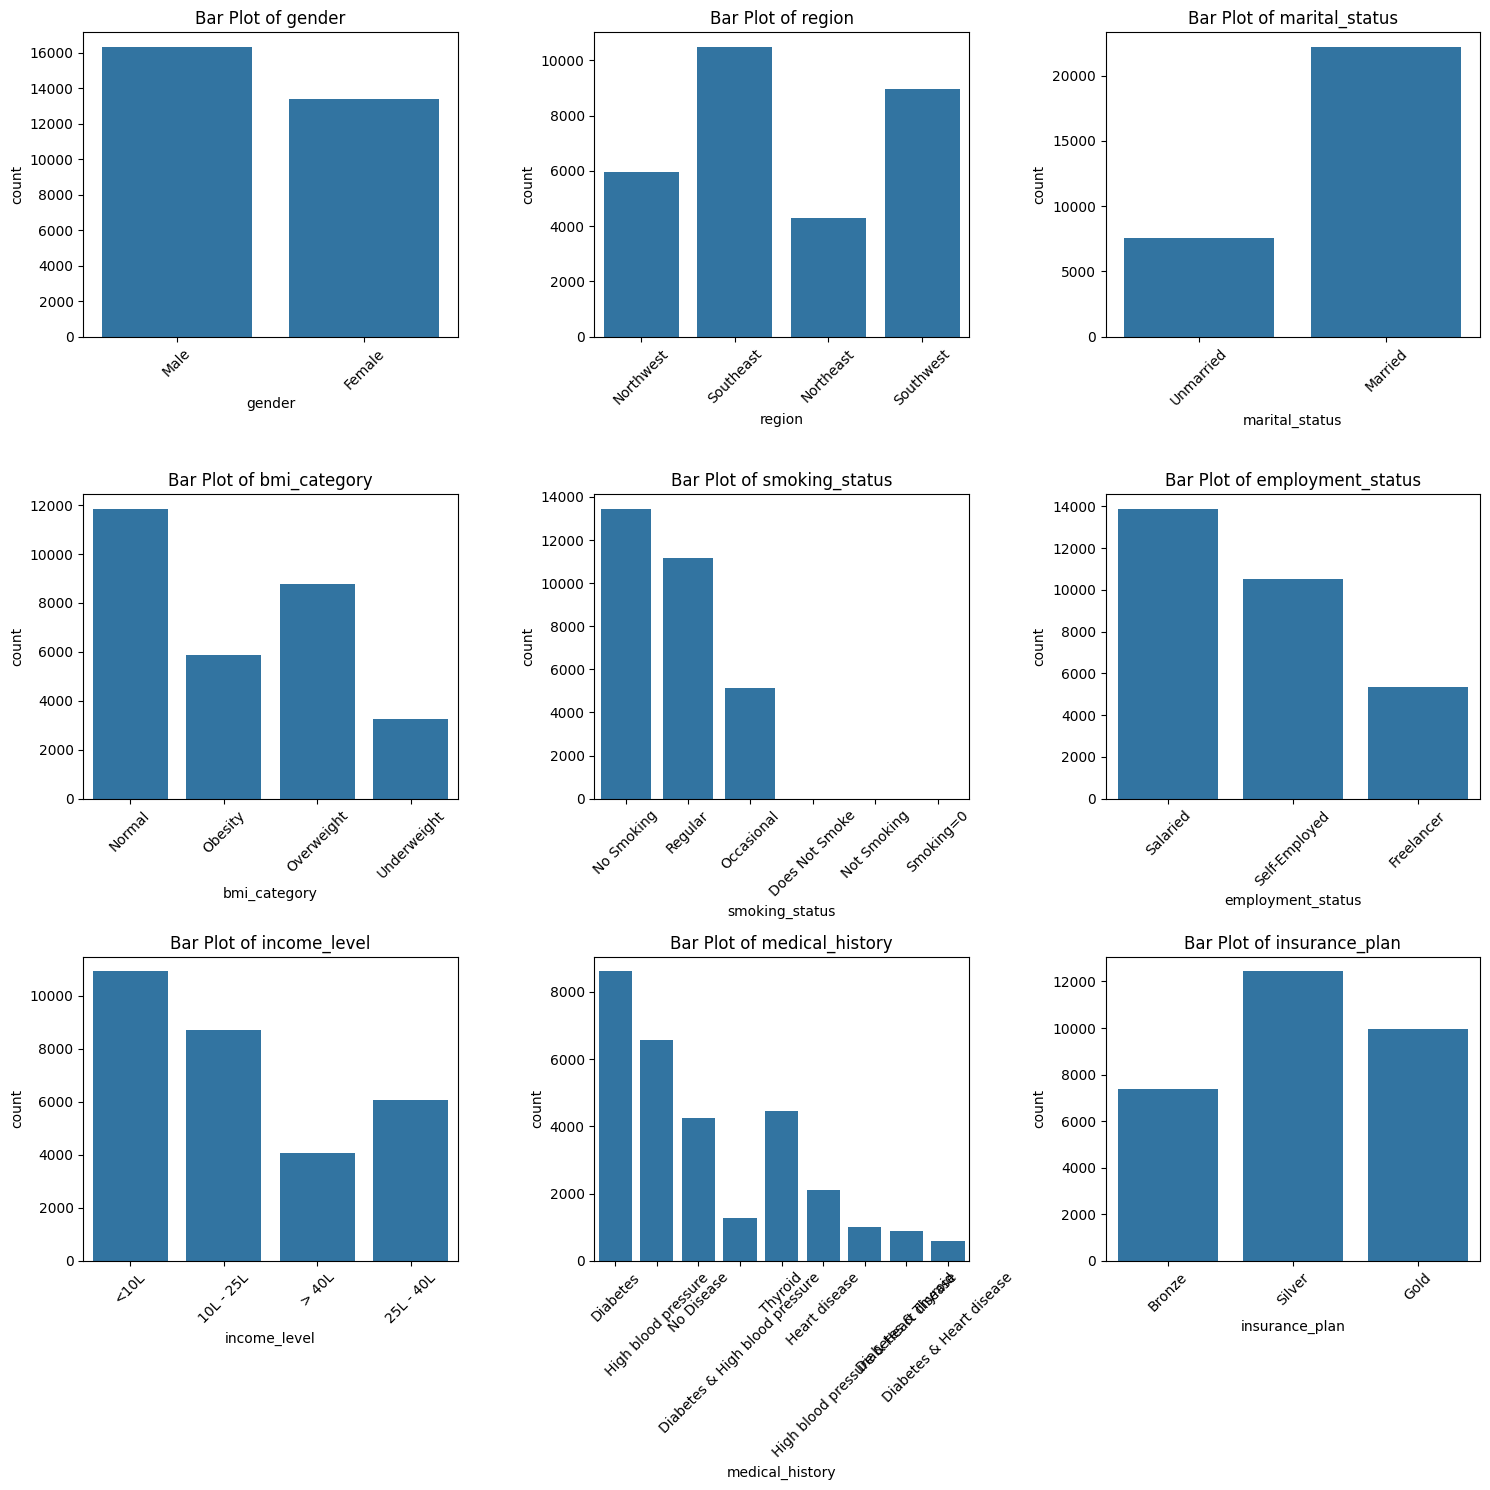

In [26]:
catogerical_cols=["gender",	"region","marital_status","bmi_category",	"smoking_status","employment_status","income_level","medical_history","insurance_plan"]
n_cols = 3
n_rows = (len(catogerical_cols) + n_cols - 1) // n_cols  # Calculate number of rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot bar plots for each categorical column
for i, col in enumerate(catogerical_cols):
    sns.countplot(x=df2[col], ax=axes[i])
    axes[i].set_title(f'Bar Plot of {col}')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Hide any empty subplots if there are any
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          806  3560    4361
25L - 40L          304  2635    3145
<10L              6067   527    4350
> 40L              214  3296     621


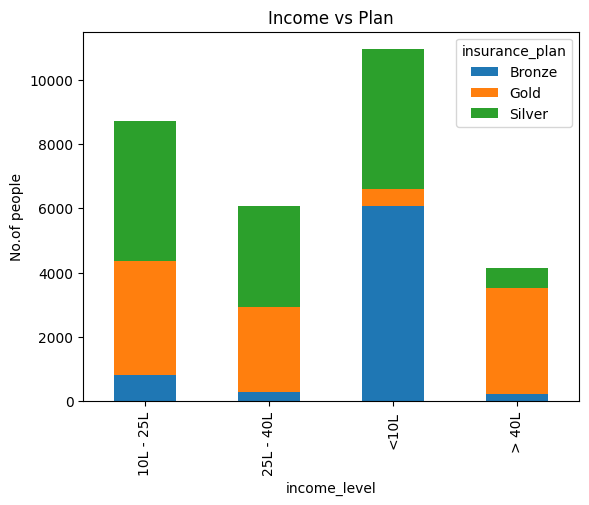

In [27]:
cross_tab=pd.crosstab(df["income_level"],df["insurance_plan"])
print(cross_tab)
cross_tab.plot(kind="bar",stacked=True)
plt.title("Income vs Plan")
plt.ylabel("No.of people")
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

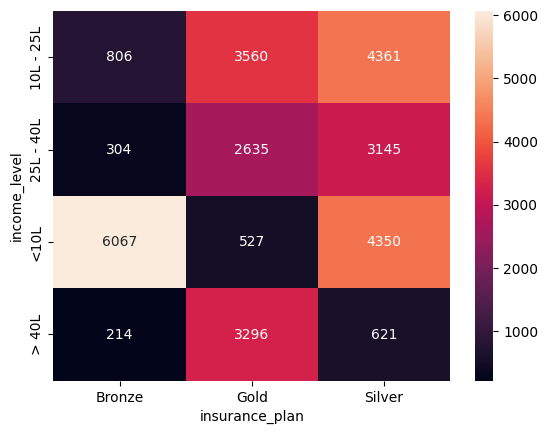

In [28]:
sns.heatmap(cross_tab, annot=True,fmt="d")


In [29]:
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303


In [30]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [31]:
risk_scores_from_client = {
    'no disease': 0,
    'diabetes': 6,
    'high blood pressure': 6,
    'thyroid': 5,
    'heart disease': 8,
    "none":0
}

#we have to use these data given by the client and convert the colums to score based on the desises they havee 
#if they have both , the summ  of the both iseeases will be his risk score


In [32]:
df2["medical_history"].str.split("&",expand=True).apply(lambda x: x.str.lower()).sample(5)

,0,1
25089,high blood pressure,None
4819,diabetes,None
28297,high blood pressure,None
25616,diabetes,None
4048,high blood pressure,None


you can see it saperated those diseases into individual columns

In [33]:
#store back those values into the data frame 
df2[["disease1","disease2"]]=df2["medical_history"].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.drop("medical_history",axis=1,inplace=True)
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,Gold,20303,no disease,None
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Bronze,15610,diabetes,None


In [34]:
df2["disease1"].fillna("none",inplace=True)
df2["disease2"].fillna("none",inplace=True)
df2["total_risk_score"]=0

In [35]:
for disease in ["disease1","disease2"]:
    df2["total_risk_score"]+=df2[disease].map(risk_scores_from_client)

max_score=df2["total_risk_score"].max()
min_score=df2["total_risk_score"].min()
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,diabetes,none,6
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,diabetes,none,6
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,high blood pressure,none,6


In [36]:
df2["normalized_risk_score"]=(df2["total_risk_score"]-min_score)/(max_score-min_score)
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,Silver,18164,high blood pressure,none,6,0.428571


In [37]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [38]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2.insurance_plan.unique()

array([1, 2, 3])

In [39]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [40]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3,'> 40L':4})
df2.income_level.unique()

array([1, 2, 4, 3])

In [41]:
df2["smoking_status"].replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)

In [42]:
#remaining are nomnal columns , so we have to use one hot encoding
nominal_cloumns=['gender', 'region', 'marital_status','bmi_category', 'smoking_status', 'employment_status']
df3=pd.get_dummies(df2,columns=nominal_cloumns,drop_first=True,dtype=int)

In [43]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29754 entries, 0 to 29903
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              29754 non-null  int64  
 1   number_of_dependants             29754 non-null  int64  
 2   income_level                     29754 non-null  int64  
 3   income_lakhs                     29754 non-null  int64  
 4   insurance_plan                   29754 non-null  int64  
 5   annual_premium_amount            29754 non-null  int64  
 6   disease1                         29754 non-null  object 
 7   disease2                         29754 non-null  object 
 8   total_risk_score                 29754 non-null  int64  
 9   normalized_risk_score            29754 non-null  float64
 10  gender_Male                      29754 non-null  int64  
 11  region_Northwest                 29754 non-null  int64  
 12  region_Southeast       

In [44]:
df4=df3.drop(["disease1","disease2","total_risk_score"],axis=1)
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29754 entries, 0 to 29903
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              29754 non-null  int64  
 1   number_of_dependants             29754 non-null  int64  
 2   income_level                     29754 non-null  int64  
 3   income_lakhs                     29754 non-null  int64  
 4   insurance_plan                   29754 non-null  int64  
 5   annual_premium_amount            29754 non-null  int64  
 6   normalized_risk_score            29754 non-null  float64
 7   gender_Male                      29754 non-null  int64  
 8   region_Northwest                 29754 non-null  int64  
 9   region_Southeast                 29754 non-null  int64  
 10  region_Southwest                 29754 non-null  int64  
 11  marital_status_Unmarried         29754 non-null  int64  
 12  bmi_category_Obesity   

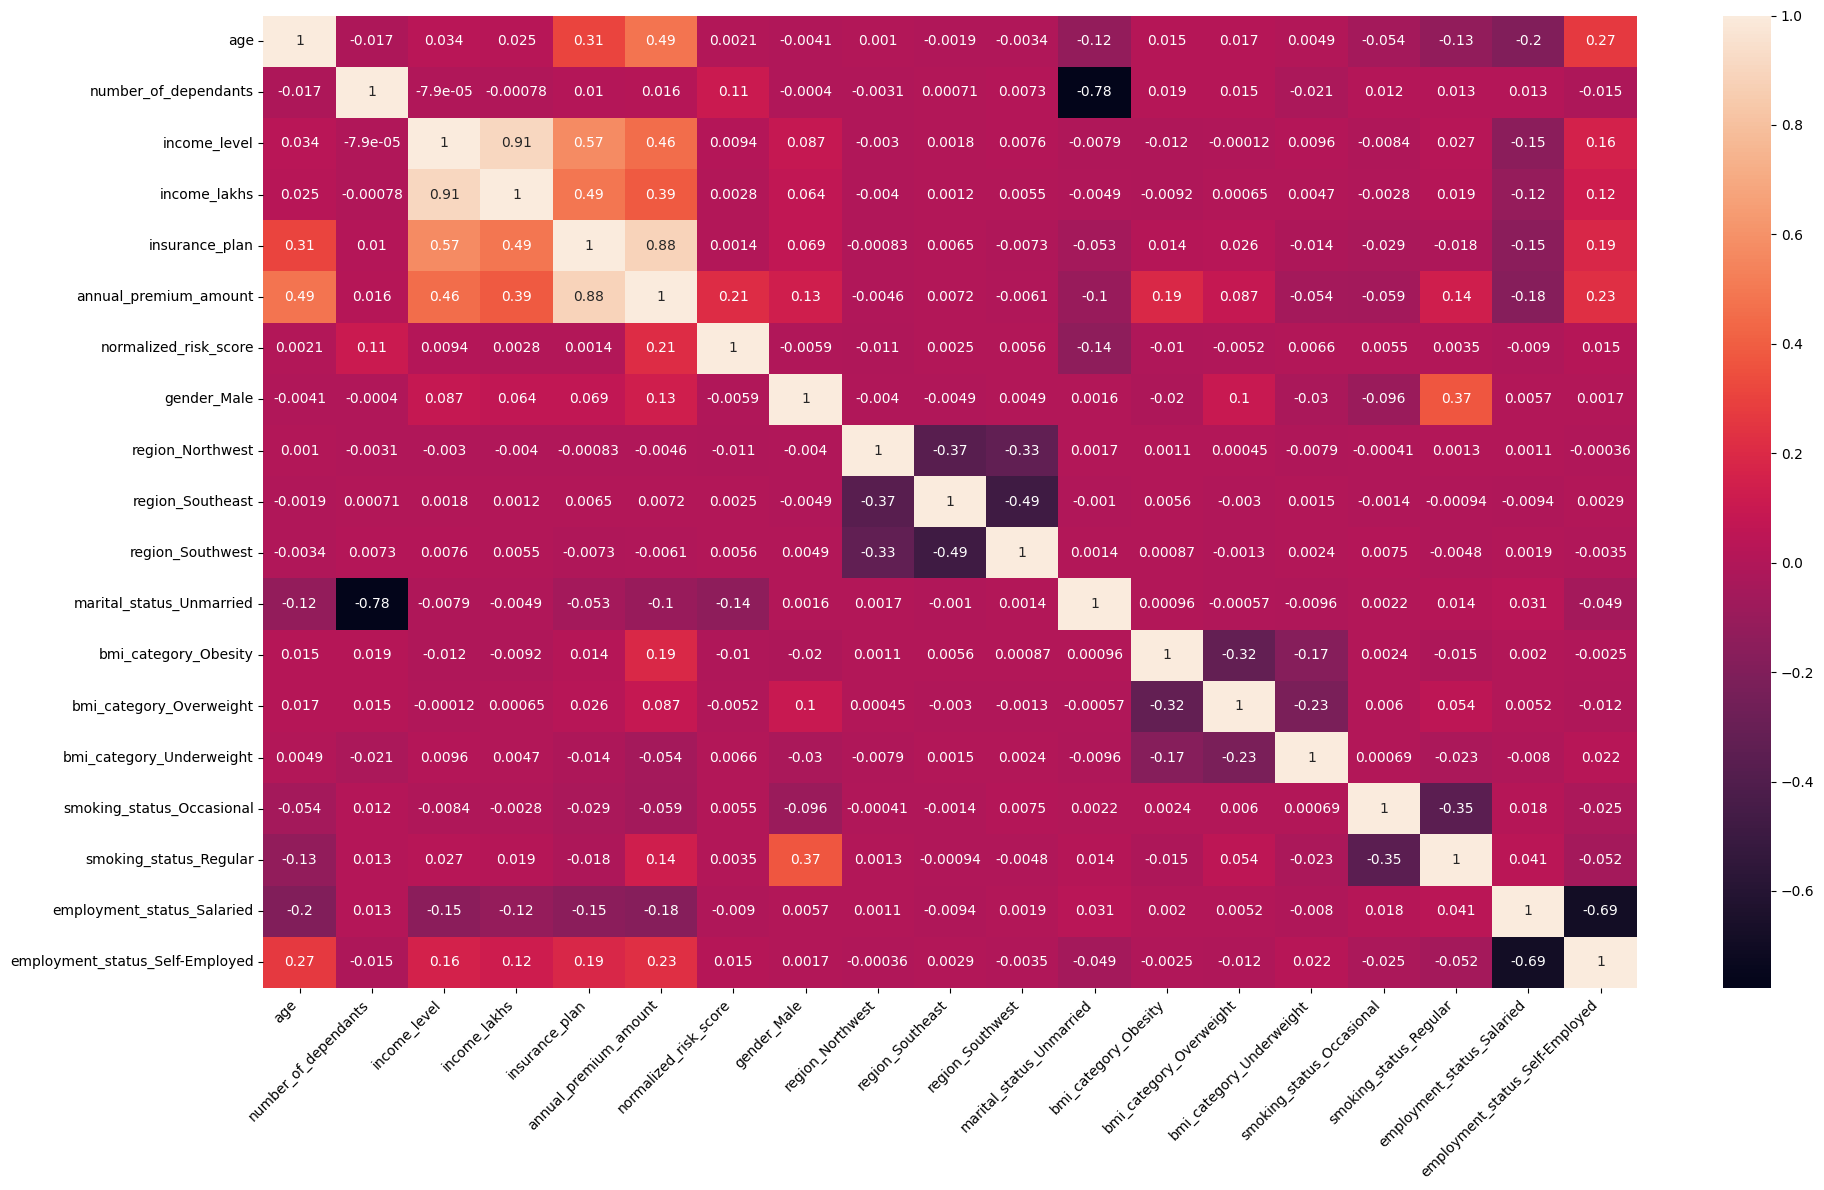

In [45]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

In [46]:
X=df4.drop("annual_premium_amount",axis=1)
y=df4.annual_premium_amount

In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
cols_to_scale=["age","income_lakhs","income_level","number_of_dependants","insurance_plan"]
X[cols_to_scale]=scaler.fit_transform(X[cols_to_scale])
X.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.051020,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.051020,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.193878,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


In [48]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000,29754.000000
mean,0.371683,0.477536,0.369788,0.225009,0.543322,0.426404,0.548968,0.200746,0.352726,0.301875,0.253378,0.196982,0.294918,0.110103,0.173254,0.374605,0.466189,0.354272
std,0.240080,0.284145,0.350221,0.226314,0.378885,0.240132,0.497605,0.400565,0.477826,0.459079,0.434953,0.397725,0.456014,0.313023,0.378473,0.484029,0.498864,0.478300
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.061224,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.163265,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.316327,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df["Column"]=data.columns
    vif_df["VIF"]=[variance_inflation_factor(data.values,i)for i in range(data.shape[1])]
    return vif_df
calculate_vif(X)

,Column,VIF
0,age,3.924740
1,number_of_dependants,6.276728
2,income_level,14.063416
3,income_lakhs,11.408527
4,insurance_plan,5.260860
5,normalized_risk_score,3.809601
6,gender_Male,2.598259
7,region_Northwest,2.123193
8,region_Southeast,2.979784
9,region_Southwest,2.708419


as income level and income lakhs have high and close vif , it means they are highly corelated , so lets drop the highest one income_level and check how the vif score wil look

In [50]:
calculate_vif(X.drop("income_level",axis=1))

,Column,VIF
0,age,3.865086
1,number_of_dependants,6.276116
2,income_lakhs,2.690925
3,insurance_plan,4.571804
4,normalized_risk_score,3.807473
5,gender_Male,2.590560
6,region_Northwest,2.122529
7,region_Southeast,2.978859
8,region_Southwest,2.706927
9,marital_status_Unmarried,2.345161


now you can see all are in same range , so we shoud drop the income level from our data.

In [51]:
X_reduced=X.drop("income_level",axis="columns")
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.051020,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.051020,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.193878,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.775510,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.132653,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Model training and fine tuning

In [52]:
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.3, random_state=10)
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_train: ",y_train.shape)

X_train:  (20827, 17)
X_test:  (8927, 17)
y_train:  (20827,)
y_train:  (20827,)


In [53]:
model_lr=LinearRegression()
model_lr.fit(X_train,y_train)
train_score=model_lr.score(X_train,y_train)
test_score=model_lr.score(X_test,y_test)
print("Train score: ",train_score)
print("Test score: ",test_score)

Train score:  0.9537747062669479
Test score:  0.952982332468962


In [54]:
from sklearn.metrics import mean_squared_error
y_pred_lr=model_lr.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred_lr)
rmse_lr=np.sqrt(mse_lr)
print("Linearregressor : MSE:'",mse_lr,"'  RMSE:'",rmse_lr,"'")

Linearregressor : MSE:' 2265696.8327823244 '  RMSE:' 1505.2231837114136 '


In [55]:
print(model_lr.coef_)
print(model_lr.intercept_)
feature_importances=model_lr.coef_

[ 6.96353453e+03 -1.31279216e+03 -7.52016885e+02  1.48577428e+04
  6.02525138e+03  5.29109471e+01 -4.19355491e+01 -4.28778476e+00
 -5.58970719e+00 -7.20469122e+02  3.95823598e+03  2.01694333e+03
  6.05139302e+02  8.29393700e+02  2.80100338e+03 -8.17751554e+01
  2.46364123e+02]
5934.164822853161


In [56]:
coeff_df=pd.DataFrame(feature_importances,columns=["coefficients"],index=X_test.columns)
coeff_df


,coefficients
age,6963.534532
number_of_dependants,-1312.792163
income_lakhs,-752.016885
insurance_plan,14857.742785
normalized_risk_score,6025.251380
gender_Male,52.910947
region_Northwest,-41.935549
region_Southeast,-4.287785
region_Southwest,-5.589707
marital_status_Unmarried,-720.469122


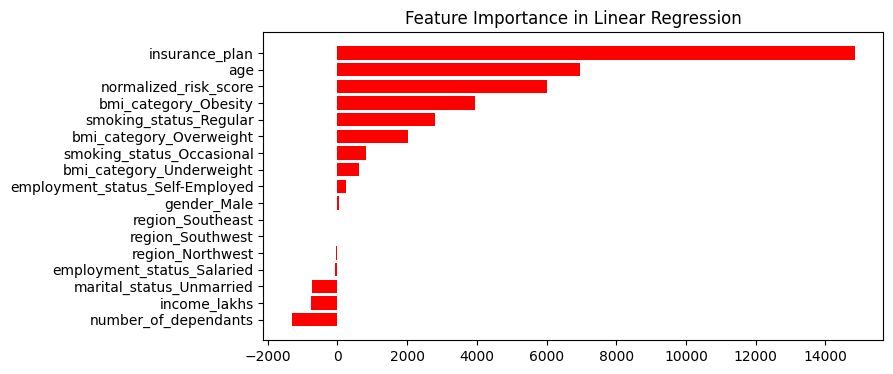

In [57]:
coeff_df_sorted = coeff_df.sort_values(by="coefficients")

# Plot the sorted horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(coeff_df_sorted.index, coeff_df_sorted["coefficients"], color="red")
plt.title("Feature Importance in Linear Regression")
plt.show()

In [58]:
from sklearn.linear_model import Ridge

model_ridge=Ridge(alpha=10)
model_ridge.fit(X_train,y_train)
train_score_ridge=model_ridge.score(X_train,y_train)
test_score_ridge=model_ridge.score(X_test,y_test)
print("Train score: ",train_score_ridge)
print("Test score: ",test_score_ridge)

Train score:  0.9537578658732027
Test score:  0.9529782683101986


In [59]:
from xgboost import XGBRegressor
model_xg=XGBRegressor(n_estimators=10,max_depth=10)
model_xg.fit(X_train,y_train)
train_score_xg=model_xg.score(X_train,y_train)
test_score_xg=model_xg.score(X_test,y_test)
print("Train score: ",train_score_xg)
print("Test score: ",test_score_xg)

Train score:  0.9974431991577148
Test score:  0.9970212578773499


In [60]:
from sklearn.metrics import mean_squared_error
y_pred_xg=model_xg.predict(X_test)
mse_xg=mean_squared_error(y_test,y_pred_xg)
rmse_xg=np.sqrt(mse_xg)
print("XGboost regressor : MSE:'",mse_xg,"'  RMSE:'",rmse_xg,"'")

XGboost regressor : MSE:' 143541.60401877726 '  RMSE:' 378.86884804477825 '


In [61]:
param_dist = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01,0.1, 0.2],
    'max_depth': [3, 4,5]
}
model_xgb=XGBRegressor()
# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter combinations to try
    scoring='r2',
    cv=3  # 3-fold cross-validation
)
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.2}
Best score:  0.9980327486991882


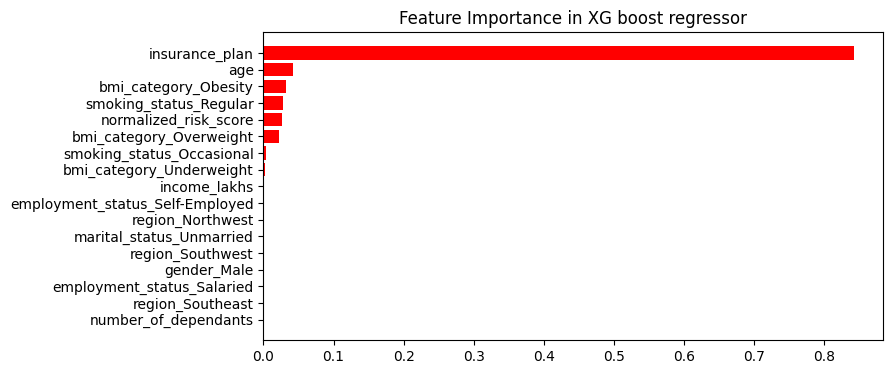

In [62]:
best_model=random_search.best_estimator_
feature_importances=best_model.feature_importances_
coeff_df=pd.DataFrame(feature_importances,columns=["coefficients"],index=X_test.columns)
coeff_df_sorted = coeff_df.sort_values(by="coefficients")

# Plot the sorted horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(coeff_df_sorted.index, coeff_df_sorted["coefficients"], color="red")
plt.title("Feature Importance in XG boost regressor")
plt.show()

##### Feature imoprtance in XGboost may not be straightforward to interpret as feature impoprtance in Linear regression, since XGboost is a tree based model

### Error Analysis

In [63]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=residuals*100/y_test 
results_df=pd.DataFrame({
    "actual":y_test,
     "predicted":y_pred,
     "diff":residuals,
     "diff_pct":residuals_pct,
})
results_df.head()

,actual,predicted,diff,diff_pct
18272,12370,12069.515625,-300.484375,-2.429138
24662,11253,11329.827148,76.827148,0.682726
1789,30688,31075.099609,387.099609,1.261404
29834,22139,22566.326172,427.326172,1.930196
1478,27040,27467.921875,427.921875,1.582551


<Axes: xlabel='diff_pct', ylabel='Count'>

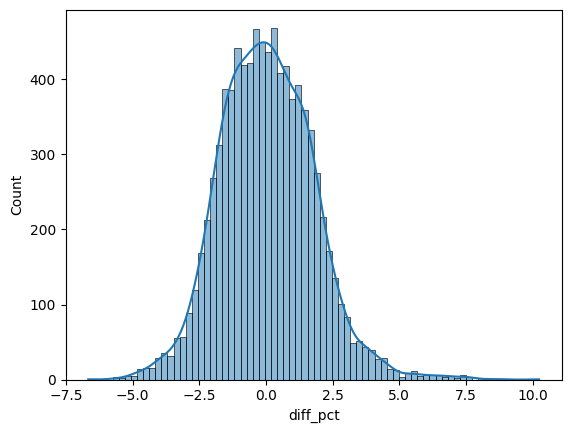

In [64]:
sns.histplot(results_df["diff_pct"],kde=True)

you can see that most of the errors are less than 10% 

In [65]:
#lets asssume our business owner givn a limit of  10%, lets see how many lies more than 10%
extreme_error_threshold=10
results_df[np.abs(results_df.diff_pct)>extreme_error_threshold].count()

actual       1
predicted    1
diff         1
diff_pct     1
dtype: int64

In [66]:
extreme_results_df=results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]

In [67]:
#calculate the percentage of errers more than 10%
extreme_error_pct= extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.01120197154699227

##### only 0.01 of my errors are extreme errors  more than 10%!!

In [68]:
#lets check how many records have more than 50%error
extreme_error_threshold=50
print("No. of erros more than 50%: ",results_df[np.abs(results_df.diff_pct)>extreme_error_threshold].actual.count())
results_df[np.abs(results_df.diff_pct)>extreme_error_threshold].sort_values(by="diff_pct",ascending=False)

No. of erros more than 50%:  0


,actual,predicted,diff,diff_pct


##### so we didnt have  problem we can deploy this model !!

In [69]:
#lets see the X_test data for which the exreme error is more
#so acces X_test values theough the index in the extreme_results_df
extreme_errors_df=X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
7547,0.347826,0.2,0.081633,0.0,0.0,1,0,1,0,1,0,0,0,0,0,1,0


### we have did  model segmentation to tacle the problem  and this model works absolutly well for the age group greater than 25
In real-world machine learning applications, there is no one-size-fits-all solution for most use cases. To address different scenarios, we may employ various models. This practice is known as model segmentation.

In [ ]:
from  joblib import dump

dump(best_model,"artifacts/model_rest.joblib")